In [1]:
#import all of the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from bayes_opt import BayesianOptimization

import warnings

In [2]:
#download the edited file
df = pd.read_json('BITFINEX/IOTUSD_EDA.json')
df.reset_index(inplace=True)
df = df.rename(columns={'index':'Date'})
print(df.head())

        Date     High      Low       Mid     Last      Bid      Ask  \
0 2017-06-13  1.30000  0.41000  0.595810  0.59773  0.59400  0.59762   
1 2017-06-14  0.61010  0.47948  0.509245  0.50639  0.50639  0.51210   
2 2017-06-15  0.54470  0.29123  0.367650  0.36600  0.36600  0.36930   
3 2017-06-16  0.59900  0.30530  0.415355  0.41540  0.41531  0.41540   
4 2017-06-17  0.45116  0.39000  0.432555  0.43210  0.43210  0.43301   

      Volume  Year  Month  Day    Weekday  
0  16.000992    17      6   13    Tuesday  
1  15.950432    17      6   14  Wednesday  
2  15.675398    17      6   15   Thursday  
3  15.422886    17      6   16     Friday  
4  14.310691    17      6   17   Saturday  


The first I want to do is to have the models use the prior day's values for X, and today's values for y, so I'll be making new columns to accomodate for that.

In [3]:
#make a dataframe that contains the wanted values offset by one day, then join with the original dataframe
priors = pd.DataFrame()
priors['Previous_High'] = df['High']
priors['Previous_Mid'] = df['Mid']
priors['Previous_Low'] = df['Low']
priors['Previous_Bid'] = df['Bid']
priors['Previous_Ask'] = df['Ask']
priors['Previous_Volume'] = df['Volume']
priors['Date'] = df['Date'].apply(lambda x: x + timedelta(days=1))

#right join so it doesn't include the first row in df, as it would have null values for the Previous columns
df = df.set_index('Date')
priors = priors.set_index('Date')
df = df.join(priors, how='right') 

#redoing this to accomodate the prediction's time columns
df = df.reset_index()
df['Year'] = df['Date'].apply(lambda x: x.year-2000)
df['Month'] = df['Date'].apply(lambda x: x.month)
df['Day'] = df['Date'].apply(lambda x: x.day)
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Weekday'] = df['Date'].apply(lambda x: weekdays[x.weekday()])
df = df.set_index('Date')

print(df.tail())

               High      Low       Mid     Last      Bid      Ask     Volume  \
Date                                                                           
2021-06-24  0.84080  0.74471  0.816770  0.81872  0.81585  0.81769  15.119523   
2021-06-25  0.85290  0.75497  0.756035  0.75664  0.75544  0.75663  14.965151   
2021-06-26  0.79172  0.72787  0.766475  0.76554  0.76647  0.76648  14.630499   
2021-06-27  0.79729  0.74141  0.779180  0.77800  0.77889  0.77947  14.320934   
2021-06-28      NaN      NaN       NaN      NaN      NaN      NaN        NaN   

            Year  Month  Day   Weekday  Previous_High  Previous_Mid  \
Date                                                                  
2021-06-24    21      6   24  Thursday        0.83149      0.779140   
2021-06-25    21      6   25    Friday        0.84080      0.816770   
2021-06-26    21      6   26  Saturday        0.85290      0.756035   
2021-06-27    21      6   27    Sunday        0.79172      0.766475   
2021-06-28   

Since I've already scaled the Volume column with a logarithmic transformation and the other columns don't seem to need scaling, the next thing I'm going to do for preprocessing is create dummies for the days of the week.  While I could just turn the values back into integers, it's categorical data that I don't want my linear regression model to misinterpret.

In [4]:
#turn days of week into dummies for machine learning
df = pd.get_dummies(columns=['Weekday'], data=df)
print(df.head())

               High      Low       Mid     Last      Bid      Ask     Volume  \
Date                                                                           
2017-06-14  0.61010  0.47948  0.509245  0.50639  0.50639  0.51210  15.950432   
2017-06-15  0.54470  0.29123  0.367650  0.36600  0.36600  0.36930  15.675398   
2017-06-16  0.59900  0.30530  0.415355  0.41540  0.41531  0.41540  15.422886   
2017-06-17  0.45116  0.39000  0.432555  0.43210  0.43210  0.43301  14.310691   
2017-06-18  0.45020  0.38500  0.401530  0.40280  0.40026  0.40280  14.372543   

            Year  Month  Day  ...  Previous_Bid  Previous_Ask  \
Date                          ...                               
2017-06-14    17      6   14  ...       0.59400       0.59762   
2017-06-15    17      6   15  ...       0.50639       0.51210   
2017-06-16    17      6   16  ...       0.36600       0.36930   
2017-06-17    17      6   17  ...       0.41531       0.41540   
2017-06-18    17      6   18  ...       0.43210  

In [5]:
#for some reason the process of creating dummies is creating null values in 20 rows
print(df.shape)
df = df.dropna()
print(df.shape)
for col in df.columns:
    print(df[col][df[col].isna()])
print(df.head())

(1438, 23)
(1418, 23)
Series([], Name: High, dtype: float64)
Series([], Name: Low, dtype: float64)
Series([], Name: Mid, dtype: float64)
Series([], Name: Last, dtype: float64)
Series([], Name: Bid, dtype: float64)
Series([], Name: Ask, dtype: float64)
Series([], Name: Volume, dtype: float64)
Series([], Name: Year, dtype: int64)
Series([], Name: Month, dtype: int64)
Series([], Name: Day, dtype: int64)
Series([], Name: Previous_High, dtype: float64)
Series([], Name: Previous_Mid, dtype: float64)
Series([], Name: Previous_Low, dtype: float64)
Series([], Name: Previous_Bid, dtype: float64)
Series([], Name: Previous_Ask, dtype: float64)
Series([], Name: Previous_Volume, dtype: float64)
Series([], Name: Weekday_Friday, dtype: uint8)
Series([], Name: Weekday_Monday, dtype: uint8)
Series([], Name: Weekday_Saturday, dtype: uint8)
Series([], Name: Weekday_Sunday, dtype: uint8)
Series([], Name: Weekday_Thursday, dtype: uint8)
Series([], Name: Weekday_Tuesday, dtype: uint8)
Series([], Name: Weekda

In [6]:
X = df.drop(columns=['High', 'Low', 'Mid', 'Last', 'Bid', 'Ask', 'Volume'], inplace=False)
y = df[['Year', 'Bid', 'Ask', 'Low', 'Mid', 'High']]

In [7]:
n_splits = 10
train_indices = []
test_indices = []

tss = TimeSeriesSplit(n_splits = n_splits)
for train_index, test_index in tss.split(X):
    train_indices.append(train_index)
    test_indices.append(test_index)

In [8]:
#linear regression model Bid MSE scores
max_iterations = range(0, n_splits)

bid_scores = []

for i in max_iterations:
    X_train = X.iloc[train_indices[i]]
    X_test = X.iloc[test_indices[i]]
    y_train = y['Bid'].iloc[train_indices[i]]
    y_test = y['Bid'].iloc[test_indices[i]]
    lr = LinearRegression().fit(X_train, y_train)
    predictions = lr.predict(X_test)
    bid_scores.append(mean_squared_error(y_test, predictions))
    print(bid_scores[i])
    
print('The average MSE score is:', np.mean(bid_scores))

0.0683338464659847
0.011941209421639424
0.0042526195223440135
0.0009674296063614367
0.0005774669410744783
0.00023371200000646931
0.00022958201834055372
0.0002749771449151295
0.001578351164254376
0.01578736585332834
The average MSE score is: 0.010417656013824893


In [9]:
#linear regression model Ask MSE scores
ask_scores = []

for i in max_iterations:
    X_train = X.iloc[train_indices[i]]
    X_test = X.iloc[test_indices[i]]
    y_train = y['Ask'].iloc[train_indices[i]]
    y_test = y['Ask'].iloc[test_indices[i]]
    lr = LinearRegression().fit(X_train, y_train)
    predictions = lr.predict(X_test)
    ask_scores.append(mean_squared_error(y_test, predictions))
    print(ask_scores[i])
    
print('The average MSE score is:', np.mean(ask_scores))

0.06812740296941609
0.011966856366964387
0.004278079116589034
0.0009410681996542929
0.0005765905943222625
0.00023634679938788669
0.0002308373342130846
0.0002792328241345654
0.0016082772357805955
0.01578233382489692
The average MSE score is: 0.010402702526535914


Looks like the Linear Regression model is able to make decent predictions, let's see how well it fits against the actual data.  For day trading, we want to buy if the Bid price occurs before the Ask.  Ideally our projected Bid price will be between the Mid and the Low, so I'm going to reflect that in my graph.  The blue lines represent the difference between the Mid and the predicted Bid value, while the orange line reflects the Bid minus the Low.  Ideally, both of these values should stay positive, since bidding above the Mid will lead to a decrease in profits, and bidding below the low will result in no trading being done.

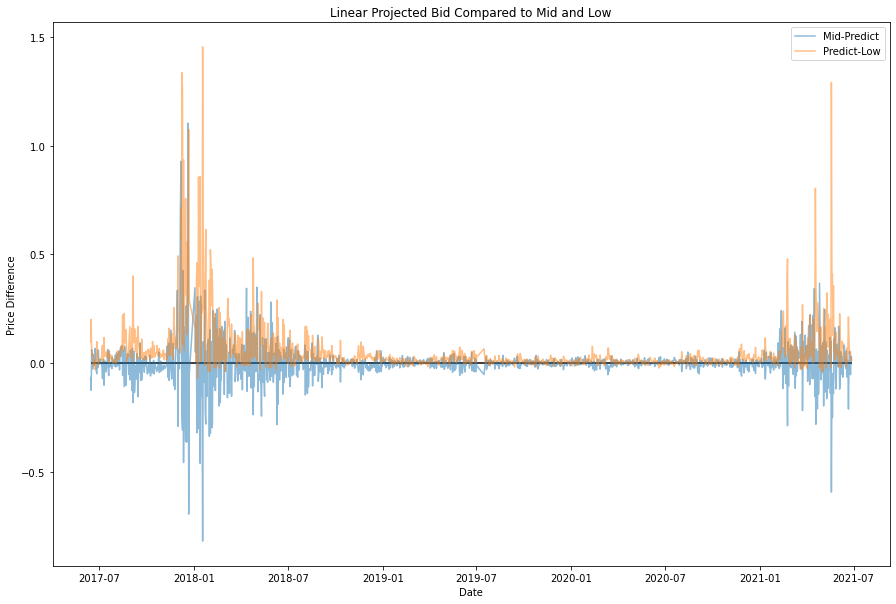

In [10]:
#linear regression model for Bid
plt.figure(figsize=(15, 10))

lr_bid = LinearRegression().fit(X.iloc[train_indices[9]], y['Bid'].iloc[train_indices[9]])
lr_bid_predictions = lr_bid.predict(X)

date_range=X.index
min_index = X.loc[date_range[0]]

plt.plot(date_range, y['Mid']-lr_bid_predictions, label='Mid-Predict', alpha=0.5)
plt.plot(date_range, lr_bid_predictions-y['Low'], label='Predict-Low', alpha=0.5)
plt.hlines(y=0, xmin=min(X.index), xmax=max(X.index), colors='black')

plt.title('Linear Projected Bid Compared to Mid and Low')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()

As you can see in the graph above, the predicted Bid value is pretty good at staying above the Low value, but seems to have trouble staying below the Mid.  We should also plot predictions for the Ask value as well.

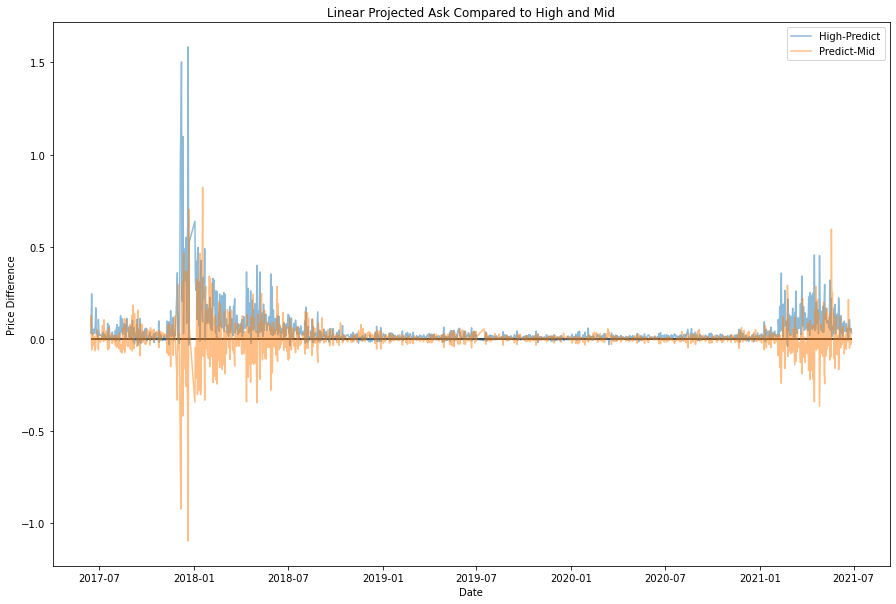

In [11]:
#linear regression model for Ask
plt.figure(figsize=(15, 10))

lr_ask = LinearRegression().fit(X.iloc[train_indices[9]], y['Ask'].iloc[train_indices[9]])
lr_ask_predictions = lr_ask.predict(X)

plt.plot(date_range, y['High']-lr_ask_predictions, label='High-Predict', alpha=0.5)
plt.plot(date_range, lr_ask_predictions-y['Mid'], label='Predict-Mid', alpha=0.5)
plt.hlines(y=0, xmin=min(X.index), xmax=max(X.index), colors='black')

plt.title('Linear Projected Ask Compared to High and Mid')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()

Similar to Bid, the projected Ask value is good at staying below the High value but gets fuzzy around the Mid.  A maximum difference of one dollar doesn't seem like much, but on a stock that caps at less than six dollars it can mean a world of difference.  That said, if either measure crosses the Mid threshold, there is still potential profit to be made as long as the Bid is always lower than the Ask, which we should check to make sure.

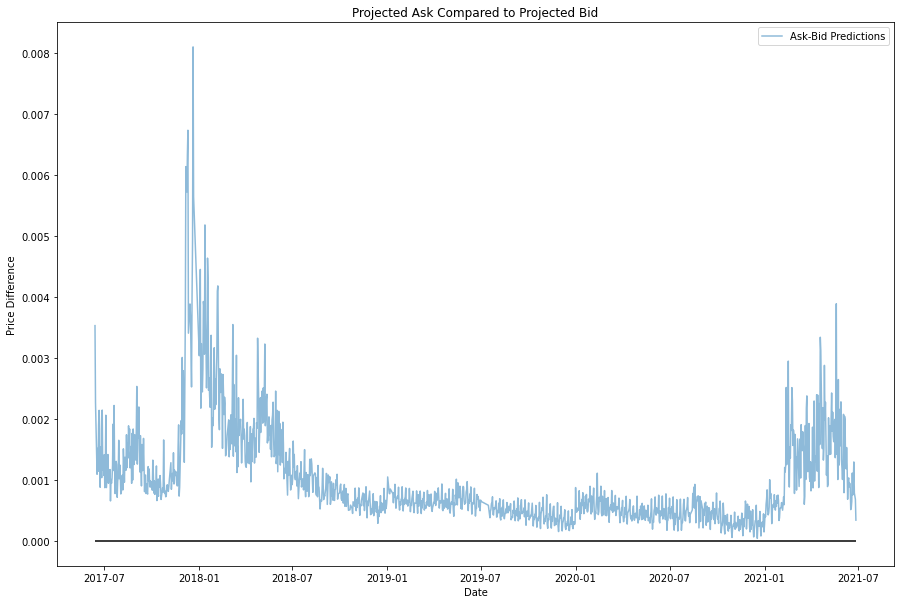

In [12]:
#linear regression model for Bid and Ask
plt.figure(figsize=(15, 10))

plt.plot(date_range, lr_ask_predictions-lr_bid_predictions, label='Ask-Bid Predictions', alpha=0.5)
plt.hlines(y=0, xmin=min(X.index), xmax=max(X.index), colors='black')

plt.title('Projected Ask Compared to Projected Bid')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()

The predicted values are consistently positive, that's reassuring.  At the very least following these Ask and Bid prices will not result in a loss, provided the Bid comes before the Ask.  Next we should use our second model, which is going to be an Auto Regressive Integrated Moving Average model, or ARIMA for short.

In [13]:
def MSE(data, input_order):
    split = int(len(data) * 0.8)
    train, test = data[0:split], data[split:len(data)]
    predictions = list()
    past = [x for x in train]
    
    for i in range(len(test)):
        model = ARIMA(past, order=input_order)
        model_fit = model.fit()
        predict = model_fit.forecast()[0]
        
        predictions.append(predict)
        past.append(test[i])
        
    error = mean_squared_error(test, predictions)
    return error

In [14]:
def optimize_ARIMA(y, p, d, q):
    best_score = float('inf')
    best_order = None
    for a in p:
        for b in d:
            for c in q:
                order = (a, b, c)
                try:
                    local_MSE = MSE(y, order)
                    if local_MSE < best_score:
                        best_score = local_MSE
                        best_order = order
                        print('new best score: ', best_score)
                        print('new best order: (', a, ', ', b, ', ', c, ')')
                    else:
                        print(a, b, c)
                except:
                    print(MSE(y, order))
                    continue
    return best_order

In [15]:
#ARIMA model
warnings.filterwarnings("ignore")
y_copy = y
#y_copy.index = y_copy.index.to_period('D')
p = [0, 1, 2]
d = [0, 1, 2]
q = [0, 1, 2]

#running optimize_ARIMA to figure out good hyperparameters.
#actual functions are commented out to prevent hours of run time when I reset the notebook.

#best_bid_order = optimize_ARIMA(y['Bid'], p, d, q)
best_bid_order = (1, 0, 0)
print(best_bid_order)

#best_ask_order = optimize_ARIMA(y['Ask'], p, d, q)
best_ask_order = (1, 0, 0)
print(best_ask_order)

ar_bid_model = ARIMA(y_copy['Bid'], order=best_bid_order)
ar_ask_model = ARIMA(y_copy['Ask'], order=best_ask_order)
ar_bid = ar_bid_model.fit()
ar_ask = ar_ask_model.fit()
print(ar_bid.summary())
print(ar_ask.summary())

(1, 0, 0)
(1, 0, 0)
                               SARIMAX Results                                
Dep. Variable:                    Bid   No. Observations:                 1418
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1287.436
Date:                Mon, 28 Jun 2021   AIC                          -2568.872
Time:                        22:23:41   BIC                          -2553.101
Sample:                             0   HQIC                         -2562.980
                               - 1418                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7065      0.572      1.235      0.217      -0.415       1.827
ar.L1          0.9915      0.002    485.653      0.000       0.988       0.996
sigma2         0.0095   7.78e-05

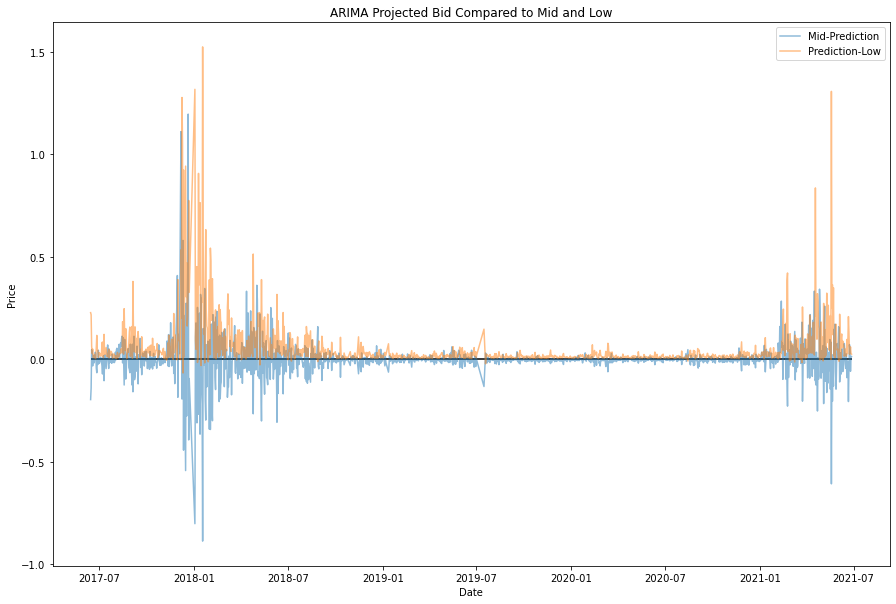

In [16]:
#ARIMA model for Bid
plt.figure(figsize=(15, 10))

ar_bid_predictions = ar_bid.predict(0, y['Bid'].count()-1)

plt.plot(y['Mid']-ar_bid_predictions, label='Mid-Prediction', alpha=0.5)
plt.plot(ar_bid_predictions-y['Low'], label='Prediction-Low', alpha=0.5)
plt.hlines(y=0, xmin=min(X.index), xmax=max(X.index), colors='black')

plt.title('ARIMA Projected Bid Compared to Mid and Low')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

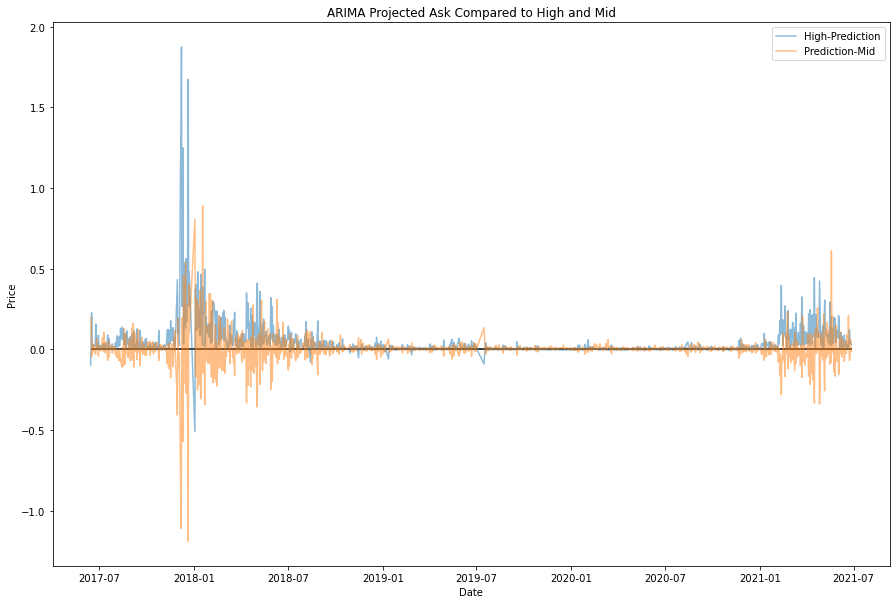

In [17]:
#ARIMA model for Ask
plt.figure(figsize=(15, 10))

ar_ask_predictions = ar_ask.predict(0, y['Ask'].count()-1)

plt.plot(y['High']-ar_ask_predictions, label='High-Prediction', alpha=0.5)
plt.plot(ar_ask_predictions-y['Mid'], label='Prediction-Mid', alpha=0.5)
plt.hlines(y=0, xmin=min(X.index), xmax=max(X.index), colors='black')

plt.title('ARIMA Projected Ask Compared to High and Mid')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

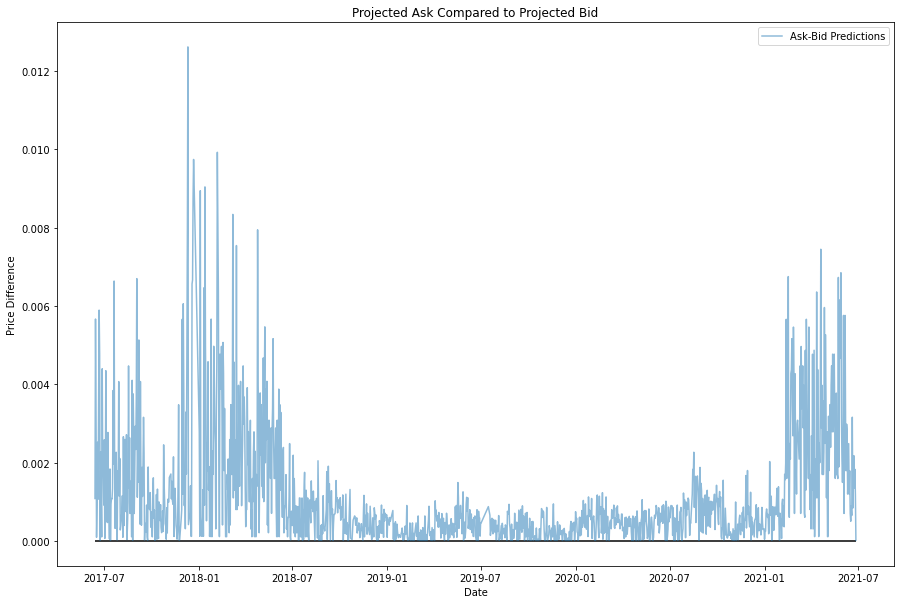

In [18]:
#ARIMA model for Bid and Ask
plt.figure(figsize=(15, 10))

plt.plot(date_range, ar_ask_predictions-ar_bid_predictions, label='Ask-Bid Predictions', alpha=0.5)
plt.hlines(y=0, xmin=min(X.index), xmax=max(X.index), colors='black')

plt.title('Projected Ask Compared to Projected Bid')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()

The ARIMA model slightly dips into negative values near the beginning and end, which is an undesireable result.  It does have a higher difference on average than the Linear model though, so the potential profits are higher as well.

So which model works best for predicting Bid and Ask values?  To find out, I will run both models through a Mean Squared Error scoring system.

In [20]:
lr_bid_MSE = mean_squared_error(y['Bid'], lr_bid_predictions)
lr_ask_MSE = mean_squared_error(y['Ask'], lr_ask_predictions)
ar_bid_MSE = mean_squared_error(y['Bid'], ar_bid.predict(0, y['Bid'].count()-1))
ar_ask_MSE = mean_squared_error(y['Ask'], ar_ask.predict(0, y['Ask'].count()-1))

print(lr_bid_MSE, ar_bid_MSE)
print(lr_ask_MSE, ar_ask_MSE)

0.008640909145413345 0.009526432746131679
0.00864850311764334 0.009542051380216824


Despite spending more time tuning the ARIMA models, it seems as though the Linear Regressor has better MSE scores.  This is mostly likely because the ARIMA model is only taking previous y values into account, while the Linear model can take multiple variables as inputs, so it has more information to work with.